Cyna Shirazinejad, 7/7/21

# Notebook 4: compare clustering models

outline:
    
* generate clustering models using alternative combinations of training sets
* check if DNM2+ events are uniformly selected by alternative models

# import all necessary Python modules

In [35]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import numpy as np
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
import itertools
import pingouin as pg
from sklearn.mixture import GaussianMixture as GMM
unique_user_saved_outputs = str(np.load('unique_user_saved_outputs.npy'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load dataframe from notebook 1

In [36]:
# load dataframe with all track features with corresponding labels for experiment number and number of imaging channels
df_merged_features = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_merged_features.zip')
df_pcs_normal_scaled_with_gmm_cluster = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_pcs_normal_scaled_with_gmm_cluster.zip')
feature_units = np.load(unique_user_saved_outputs+'/dataframes/feature_units.npy')

# look for effects of different training data combinations on results on DNM2+ predictions

In [37]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'magenta', 'grey']

In [38]:
experiment_combinations = [] # all combinations of experiments
experiment_numbers = set(df_merged_features['experiment_number'].values)
for L in range(0, len(experiment_numbers)+1):
    for subset in itertools.combinations(experiment_numbers, L):
        experiment_combinations.append(subset)

In [39]:
df = df_merged_features
mean_dnm2_max = [] # mean DNM2 intensity across DNM2+ events in model
std_dnm2_max = [] # std ""
num_exp_combo = [] # number of experiments in training data
fraction_dnm2_positive = [] # fraction of events per model that are dnm2+ (only looking at experiments used for training)

fraction_per_experiment_predicted_dnm2 = [] # check every experiment individually against model for % dnm2+ (even for experiments not used in training)
experiment_dnm2_checked = [] # the experiment being checked against every model
num_exp_combo_per_exp = [] # the number of experiments used for training the model
exp_training_single_combo = [] # only used when a single experiment is used for training, but keeps track of the 'first' experiment used in the combo of training examples

indices_dnm2_positive_all_models = []

for i, combo in tqdm(enumerate(experiment_combinations)):

    if list(combo): # do not look at empty set 

        features_combo = df[df['experiment_number'].isin(list(combo))].values[:,:len(feature_units)] # the raw features of events in experiments used for training
        normal_scaler_combo = preprocessing.QuantileTransformer(output_distribution='normal', random_state=817) # scale the features
        normal_scaled_data_combo = normal_scaler_combo.fit_transform(features_combo)
 
        pc_model_combo = PCA(n_components=2, random_state=817) # project
        reduced_data_combo = pc_model_combo.fit_transform(normal_scaled_data_combo)
        
        gmm_combo = GMM(n_components=5, random_state=817) # cluster

        gmm_prediction_combo = gmm_combo.fit_predict(reduced_data_combo)
        
        mean_dnm2_cluster = [] # find which cluster has the highest dnm2 signal
        for i in range(5):

            max_dnm2_clusters = features_combo[:,2][np.where(gmm_prediction_combo==i)[0]]

            mean_dnm2_cluster.append(np.mean(max_dnm2_clusters))

        cluster_max_dnm2 = np.argmax(mean_dnm2_cluster) # index of cluster with highest dnm2 signal, on average
        
        indices_dnm2_positive = np.where(gmm_prediction_combo==cluster_max_dnm2)[0] # event indices of dnm2+ events
        
        dnm2_max_combo_dnm2_positive = features_combo[:,2][indices_dnm2_positive] # max dnm2 signal per event for dnm2+
        
        mean_dnm2_max.append(np.mean(dnm2_max_combo_dnm2_positive))
        std_dnm2_max.append(np.std(dnm2_max_combo_dnm2_positive))
        num_exp_combo.append(len(list(combo)))
        fraction_dnm2_positive.append(len(indices_dnm2_positive)/len(gmm_prediction_combo))
#         print(len(indices_dnm2_positive)/len(gmm_prediction_combo))

        all_features = df.values[:,:len(feature_units)] # all experiments
        
        scaled_all_data = normal_scaler_combo.transform(all_features) 
        # scale all data (data that already has been scaled should be 
        # where it was above, new data will be scaled using the 
        # quantiles set by this already-trained scaler)
        
        all_pcs = pc_model_combo.transform(scaled_all_data) # project and cluster all data
        
        all_gmm_preds = gmm_combo.predict(all_pcs)
        
        all_indices_dnm2_positive = np.where(all_gmm_preds==cluster_max_dnm2)[0]
        
        indices_dnm2_positive_all_models.append(all_indices_dnm2_positive)
        
        for exp_num in set(df['experiment_number'].values): # iterate over all experiments
            
            indices_experiment = list(df[df['experiment_number'].isin([exp_num])].index) # find events for experiment
            
            indices_dnm2_pos_exp = set(indices_experiment).intersection(all_indices_dnm2_positive) # find dnm2+ events in experiment
#             print(len(indices_dnm2_pos_exp)/len(indices_experiment))
            fraction_per_experiment_predicted_dnm2.append(len(indices_dnm2_pos_exp)/len(indices_experiment)) # fraction of events in experiment that are dnm2+
            experiment_dnm2_checked.append(exp_num) # exp number used for inference
            num_exp_combo_per_exp.append(len(list(combo))) # num experiments used for training
            exp_training_single_combo.append(combo[0]) # this will be checked only for len(combo)==1, but find the datapoint used for training the model

256it [03:55,  1.09it/s]


In [40]:
np.save(unique_user_saved_outputs+'/dataframes/mean_dnm2_max', mean_dnm2_max)
np.save(unique_user_saved_outputs+'/dataframes/std_dnm2_max', std_dnm2_max)
np.save(unique_user_saved_outputs+'/dataframes/num_exp_combo', num_exp_combo)
np.save(unique_user_saved_outputs+'/dataframes/fraction_dnm2_positive', fraction_dnm2_positive)
np.save(unique_user_saved_outputs+'/dataframes/fraction_per_experiment_predicted_dnm2', fraction_per_experiment_predicted_dnm2)
np.save(unique_user_saved_outputs+'/dataframes/experiment_dnm2_checked', experiment_dnm2_checked)
np.save(unique_user_saved_outputs+'/dataframes/num_exp_combo_per_exp', num_exp_combo_per_exp)
np.save(unique_user_saved_outputs+'/dataframes/exp_training_single_combo', exp_training_single_combo)

In [41]:
mean_dnm2_max = np.load(unique_user_saved_outputs+'/dataframes/mean_dnm2_max.npy')
std_dnm2_max = np.load(unique_user_saved_outputs+'/dataframes/std_dnm2_max.npy')
num_exp_combo = np.load(unique_user_saved_outputs+'/dataframes/num_exp_combo.npy')
fraction_dnm2_positive = np.load(unique_user_saved_outputs+'/dataframes/fraction_dnm2_positive.npy')
fraction_per_experiment_predicted_dnm2 = np.load(unique_user_saved_outputs+'/dataframes/fraction_per_experiment_predicted_dnm2.npy')
experiment_dnm2_checked = np.load(unique_user_saved_outputs+'/dataframes/experiment_dnm2_checked.npy')
num_exp_combo_per_exp = np.load(unique_user_saved_outputs+'/dataframes/num_exp_combo_per_exp.npy')
exp_training_single_combo = np.load(unique_user_saved_outputs+'/dataframes/exp_training_single_combo.npy')

In [42]:
%%capture
fig, axes = plt.subplots(1,3, dpi=500, figsize=(8,2))
axes[0].hist(mean_dnm2_max, bins='doane', density=True);
axes[0].set_xlabel('mean DNM2 max intensity \nfor DNM2+ events in model')
axes[1].hist(std_dnm2_max, bins='auto', density=True);
axes[1].set_xlabel('standard deviation of DNM2 max\nintensity for DNM2+ events in model')
axes[2].hist(fraction_dnm2_positive, bins='auto', density=True);
axes[2].set_xlabel('fraction of DNM2+ events in model')
axes[0].set_ylabel('frequency density')
axes[1].set_ylabel('frequency density')
axes[2].set_ylabel('frequency density')
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/stats_dnm2pos_variousmodels.png', bbox_inches='tight')

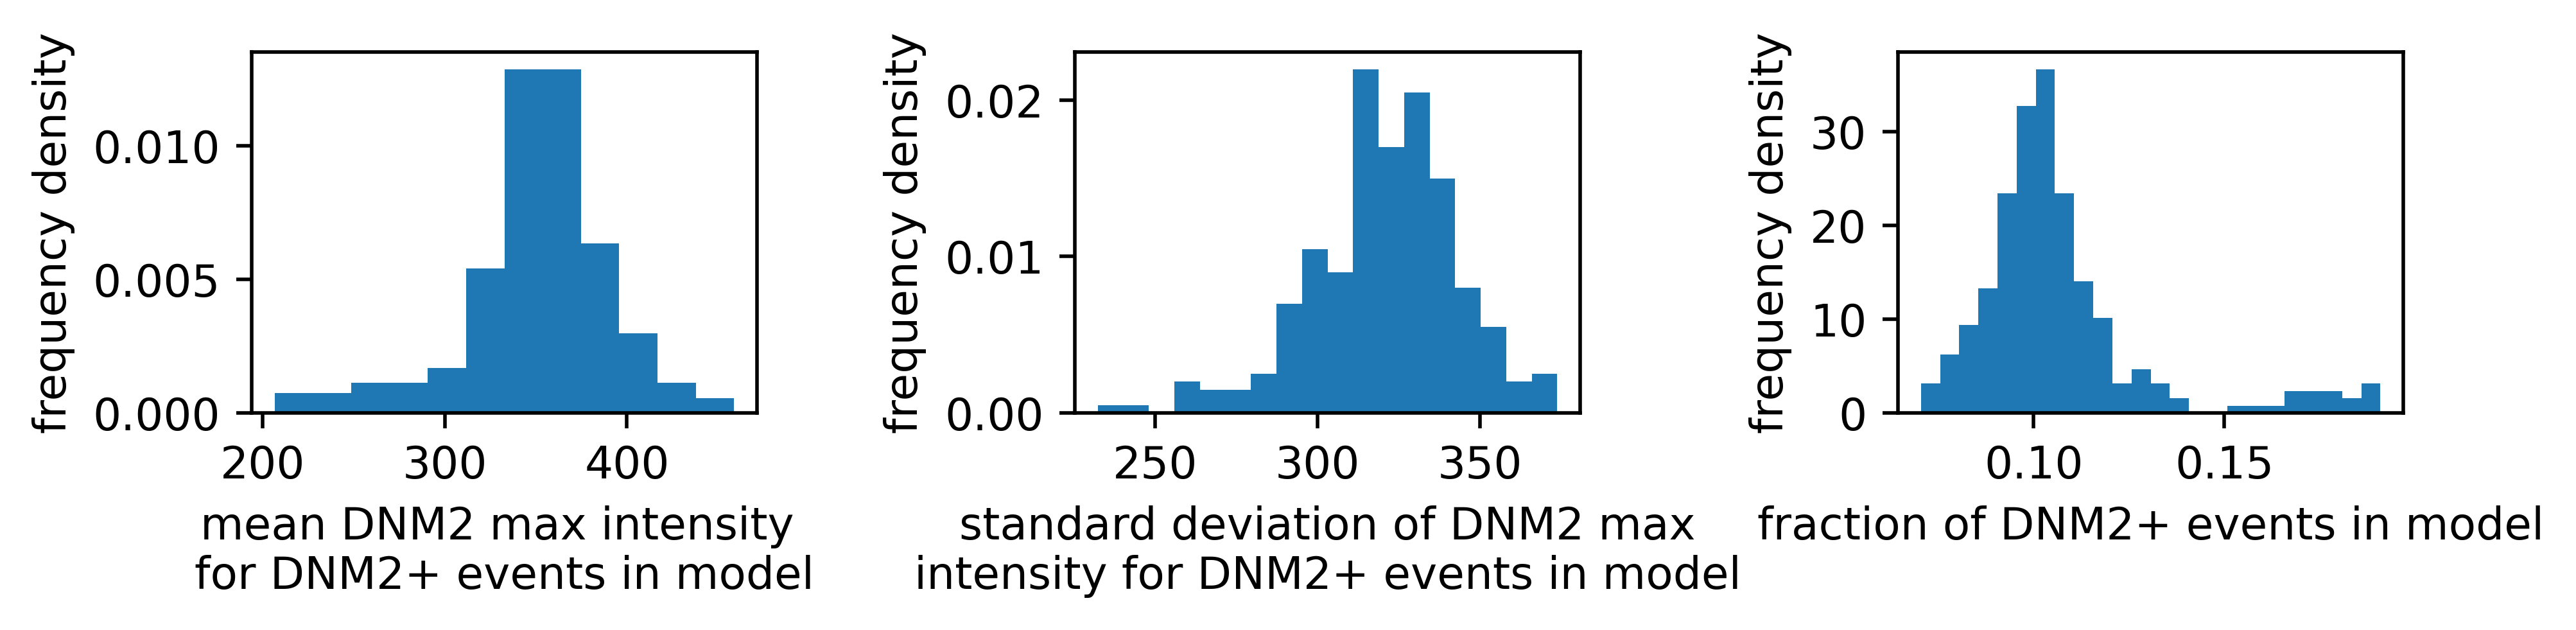

In [43]:
Image(filename=unique_user_saved_outputs+'/plots/stats_dnm2pos_variousmodels.png', height=500, width=500)

In [44]:
%%capture

plt.figure(figsize=(15,5), dpi=1000)

fraction_dnm2pos_num_exp_training_and_exp_num = []

for i in range(len(fraction_per_experiment_predicted_dnm2)):
    
    num_in_combo = num_exp_combo_per_exp[i]
#     print(int(experiment_dnm2_checked[i]))
    color = colors[int(experiment_dnm2_checked[i])]
#     print(fraction_per_experiment_predicted_dnm2[i])
#     print(num_in_combo+0.25, fraction_per_experiment_predicted_dnm2[i])
#     print(num_in_combo+0.1+0.1*int(experiment_dnm2_checked[i]))
#     print(color)
    plt.plot(num_in_combo+0.1+0.1*int(experiment_dnm2_checked[i]), fraction_per_experiment_predicted_dnm2[i], '.', color=color, markersize=1)
    
    fraction_dnm2pos_num_exp_training_and_exp_num.append([int(experiment_dnm2_checked[i]), num_in_combo, fraction_per_experiment_predicted_dnm2[i]])
    
plt.plot(num_exp_combo, fraction_dnm2_positive, '.b')
for i in range(8):
    plt.plot(num_exp_combo[i], fraction_dnm2_positive[i], '.', c=colors[i])
for i in range(1,9):
    plt.axvspan(i-0.05, i+0.05, color='yellow', alpha=0.5)
plt.ylabel('fraction of events DNM2 positive')
x_ticks = []
x_tick_labels = []
for i in range(8):
    if i==0:
        x_tick_labels.append('*'+str(i+1)+' total experiment')
    else:
        x_tick_labels.append('*'+str(i+1)+' total experiments')
    x_ticks.append(i+1)
    for j in range(8):
        x_tick_labels.append('**'+'experiment '+str(j))
        x_ticks.append(i+1+0.1+0.1*j)
plt.xticks(x_ticks, labels=x_tick_labels, rotation=90);

means_each_exp_per_num_datasets = [[] for i in range(8)]

for i in range(1,9):
    
    indices_num_experiments = np.where(np.array(num_exp_combo)==i)[0]
    fractions_n_exp = np.mean(np.array(fraction_dnm2_positive)[indices_num_experiments])
    mean_fractions_overlap = np.mean(np.array(fraction_dnm2_positive)[indices_num_experiments])
    variance_fractions = np.var(np.array(fraction_dnm2_positive)[indices_num_experiments])
    max_y = np.max(np.array(fraction_dnm2_positive)[indices_num_experiments])
    plt.text(i, 
             0.43, 
             'mean: ' + "{:.2e}".format(mean_fractions_overlap)+ '\nvariance: ' + "{:.2e}".format(variance_fractions), 
             rotation=90, 
             horizontalalignment='center', 
             fontsize=3,
             backgroundcolor='cyan',
             verticalalignment='top')
    plt.axhline(fractions_n_exp, color='b', alpha=0.1, linestyle='-')
    
    for j in range(1,9):
        indices_exp_individual = np.where(np.array(experiment_dnm2_checked)==j-1)[0]
        indices_num_in_combo = np.where(np.array(num_exp_combo_per_exp)==i)[0]
        indices_overlap = list(set(indices_exp_individual).intersection(indices_num_in_combo))
        fractions_overlap = np.array(fraction_per_experiment_predicted_dnm2)[indices_overlap]
        mean_fractions_overlap = np.mean(fractions_overlap)
        means_each_exp_per_num_datasets[j-1].append((j-1, mean_fractions_overlap))
        plt.axhline(mean_fractions_overlap, color=colors[j-1], alpha=0.1)
        variance_fractions = np.var(fractions_overlap)
        max_y = np.max(np.array(fractions_overlap))
        plt.text(i+0.1*j, 
                 0.43, 
                 'mean: ' + "{:.2e}".format(mean_fractions_overlap)+ '\nvariance: ' + "{:.2e}".format(variance_fractions), 
                 rotation=90, 
                 horizontalalignment='center', 
                 backgroundcolor='white', 
                 fontsize=3,
                 verticalalignment='top')
    
plt.ylim(0, 0.45)
plt.xlim(0.8, 9)
plt.yticks(list(np.arange(0,0.5,0.05)), labels=[str(np.around(x,2)) for x in np.arange(0,0.5,0.05)], rotation=90, verticalalignment='center')
plt.title("*: training data, **: testing data;"+
          "\ntraining data predictions are computed for all combinations of N experiments' models;"+
          "\ntesting data is subject to prediction for every experiment against all training models;"+
          "\ncolors in single-experiment training models correspond to testing data predictions")
# plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/boostrap_fraction_dnm2_positive.png', bbox_inches='tight')

In [45]:
Image(filename=unique_user_saved_outputs+'/plots/boostrap_fraction_dnm2_positive.png', height=500, width=500)

In [46]:
%%capture

plt.figure(dpi=500)
for i in range(8):
    
    means_exp = means_each_exp_per_num_datasets[i]
    for mean in means_exp:
#         print(mean[0], mean[1])
#         print(colors[i])
        plt.plot(mean[0], mean[1], '.', color=colors[i], markersize=5)
for i in range(8):
    plt.plot(i, fraction_dnm2_positive[i], '.', c=colors[i], markersize=10, marker='*')  
plt.axhline(fraction_dnm2_positive[-1])
# for j,i in enumerate(range(8)):
#     plt.plot(j, fraction_per_experiment_predicted_dnm2[-i], c=colors[j], marker='o')
k=0
for i in range(len(fraction_per_experiment_predicted_dnm2)):
    if num_exp_combo_per_exp[i]==8:
        plt.plot(experiment_dnm2_checked[i], fraction_per_experiment_predicted_dnm2[i], c=colors[k], marker='o')
        k+=1
plt.ylim(0.04, 0.23)
plt.xlabel('experiment number')
plt.ylabel('fraction DNM2 positive from\npredictions of each N-dataset(s) training model')
plt.title('- blue line is the aggregate model fraction\n- stars are predictions from a single dataset model\n- large circles are aggregate model predictions per experiment')
plt.savefig(unique_user_saved_outputs+'/plots/boostrapped_dnm2_pos_fractions_averages_across_training_models_ndatasets_mean_and_individual_pred_labeled.png', bbox_inches='tight')

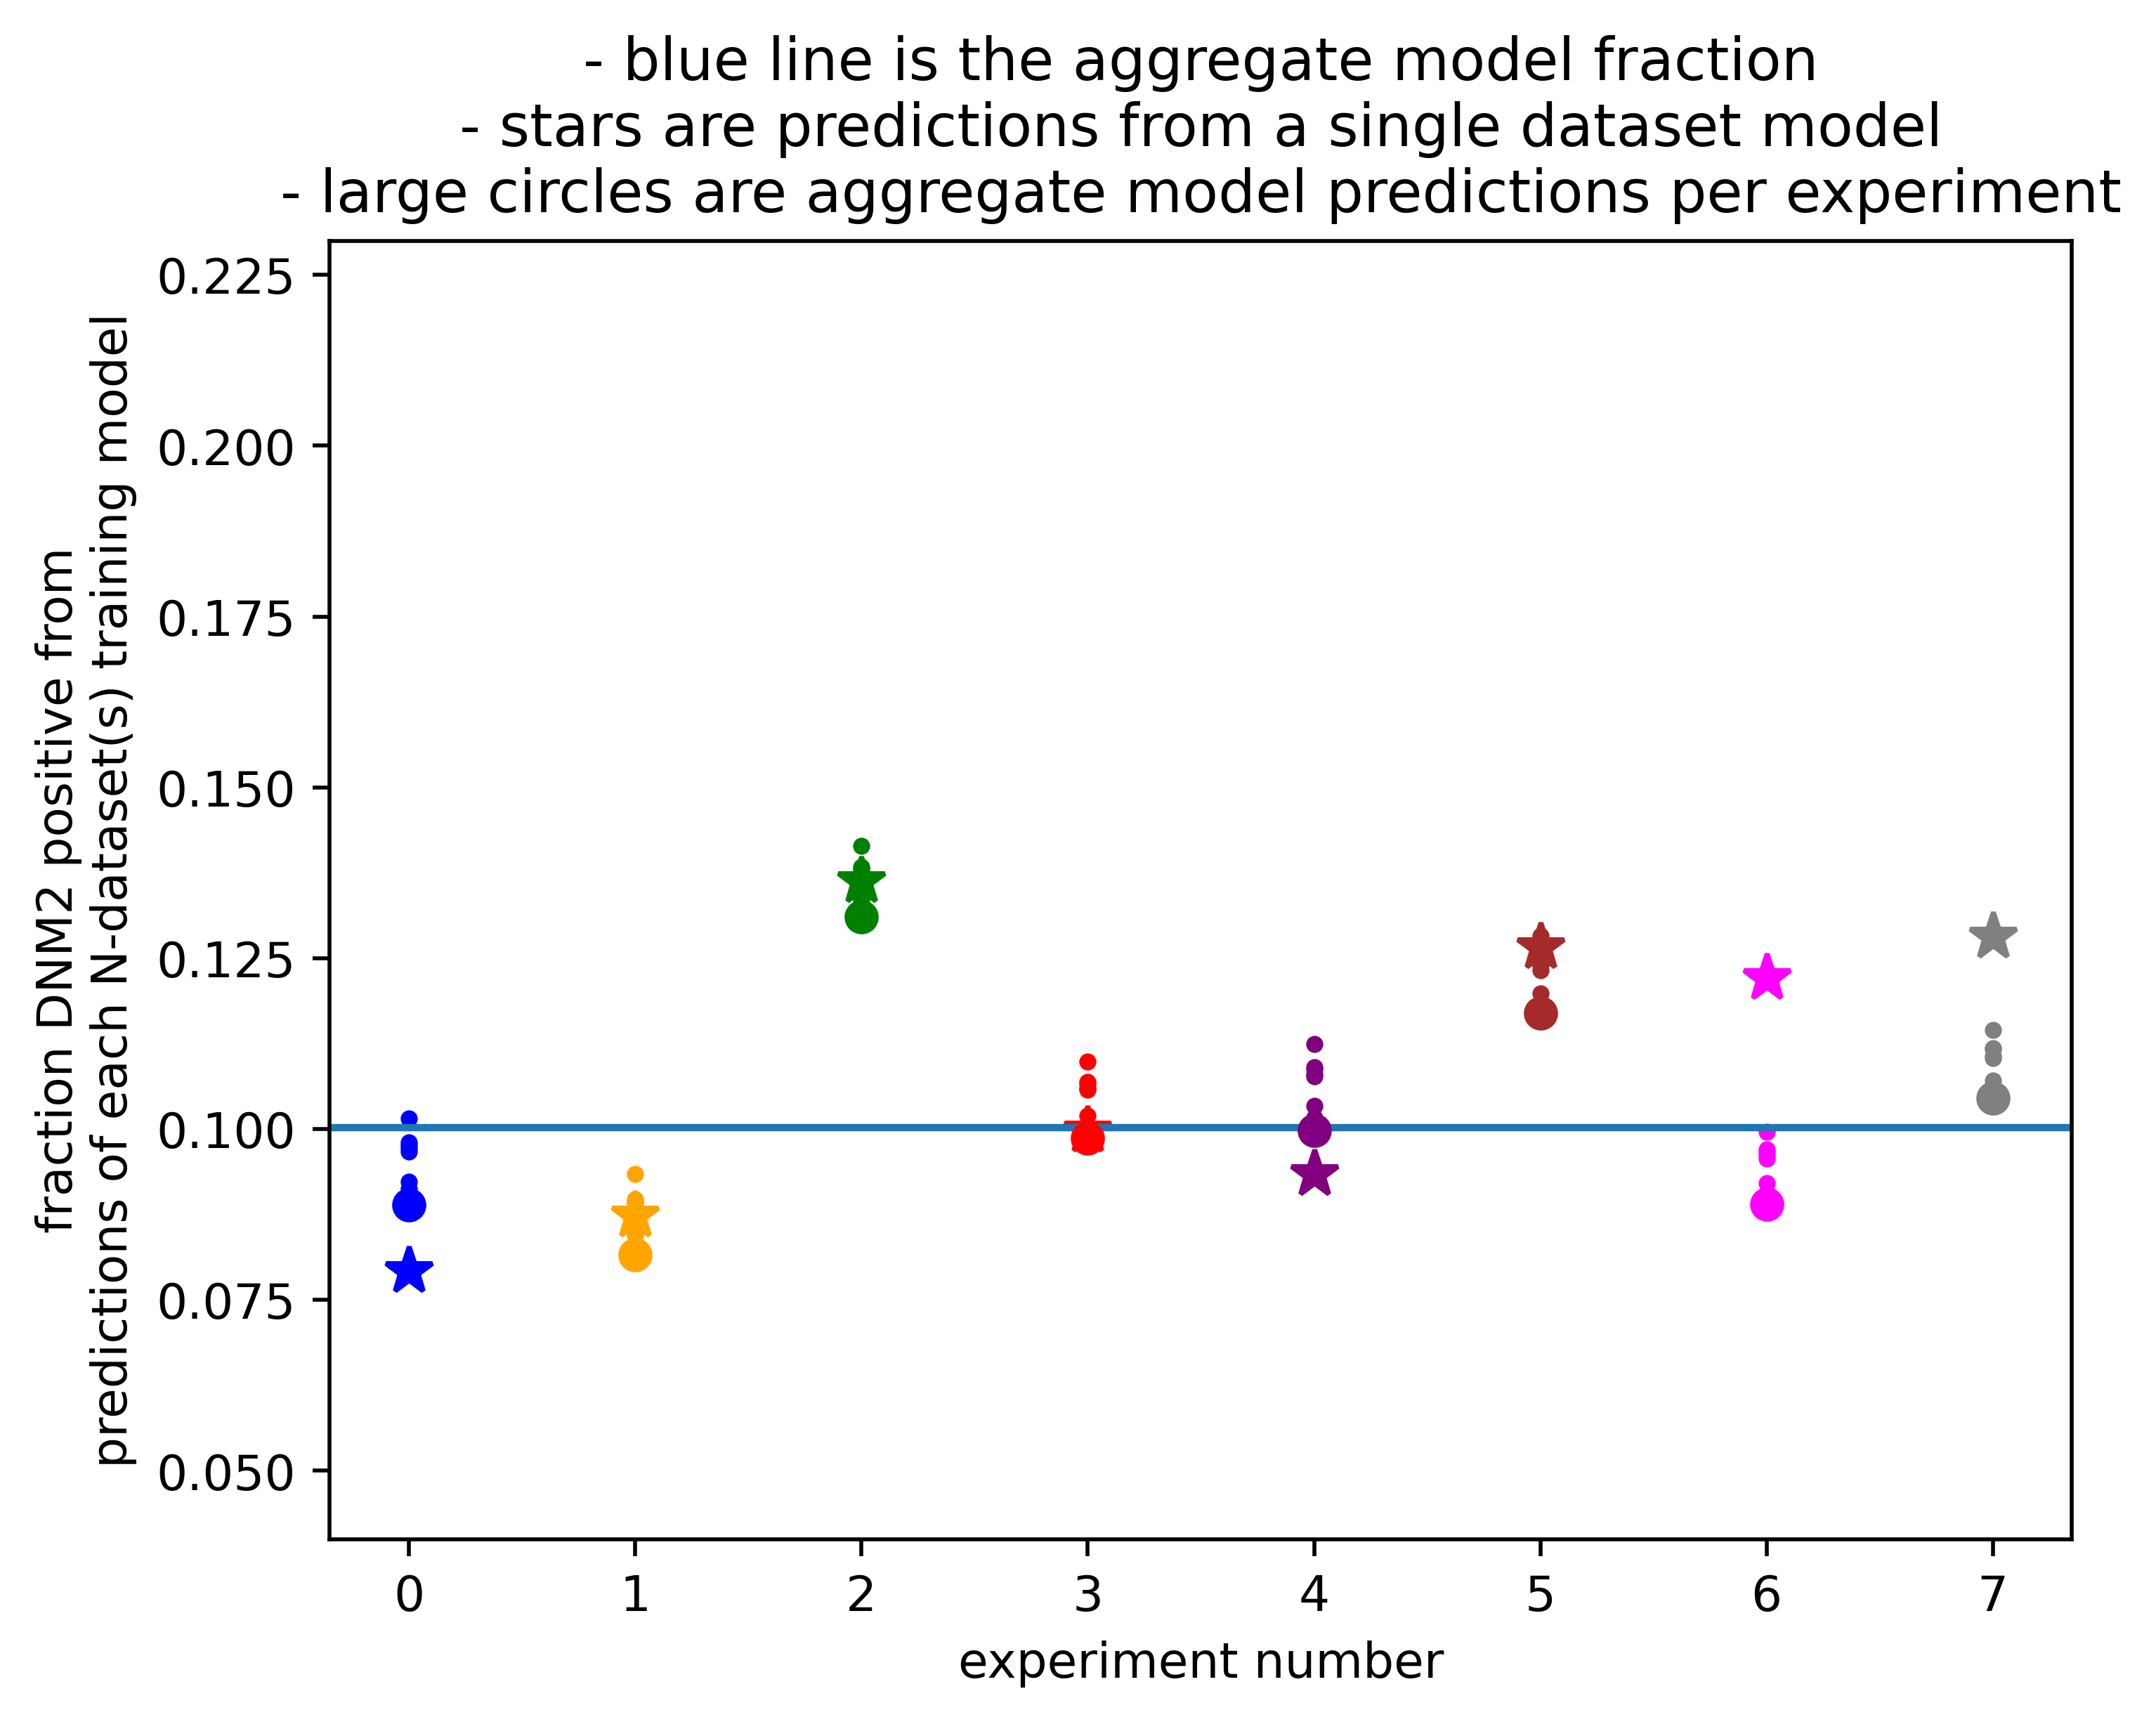

In [47]:
Image(filename=unique_user_saved_outputs+'/plots/boostrapped_dnm2_pos_fractions_averages_across_training_models_ndatasets_mean_and_individual_pred_labeled.png', height=500, width=500)

In [48]:
df_fraction_num_training_and_exp_num = pd.DataFrame(data=fraction_dnm2pos_num_exp_training_and_exp_num, columns=['experiment', 'number_training', 'fraction'])

In [49]:
# save the dataframe for subsequent notebooks
compression_opts = dict(method='zip',
                        archive_name=unique_user_saved_outputs+'/dataframes/df_fraction_num_training_and_exp_num.csv')  

df_fraction_num_training_and_exp_num.to_csv(unique_user_saved_outputs+'/dataframes/df_fraction_num_training_and_exp_num.zip', index=False,
                                                          compression=compression_opts) 

In [50]:
df_fraction_num_training_and_exp_num = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_fraction_num_training_and_exp_num.zip')


In [51]:
%%capture
plt.rcParams['figure.dpi']=500
sns.catplot(data=df_fraction_num_training_and_exp_num, x='experiment', y='fraction', hue='number_training')
plt.ylabel('fraction DNM2+')
plt.savefig(unique_user_saved_outputs+'/plots/fractiondnm2_exp_num_training.png', bbox_inches='tight')

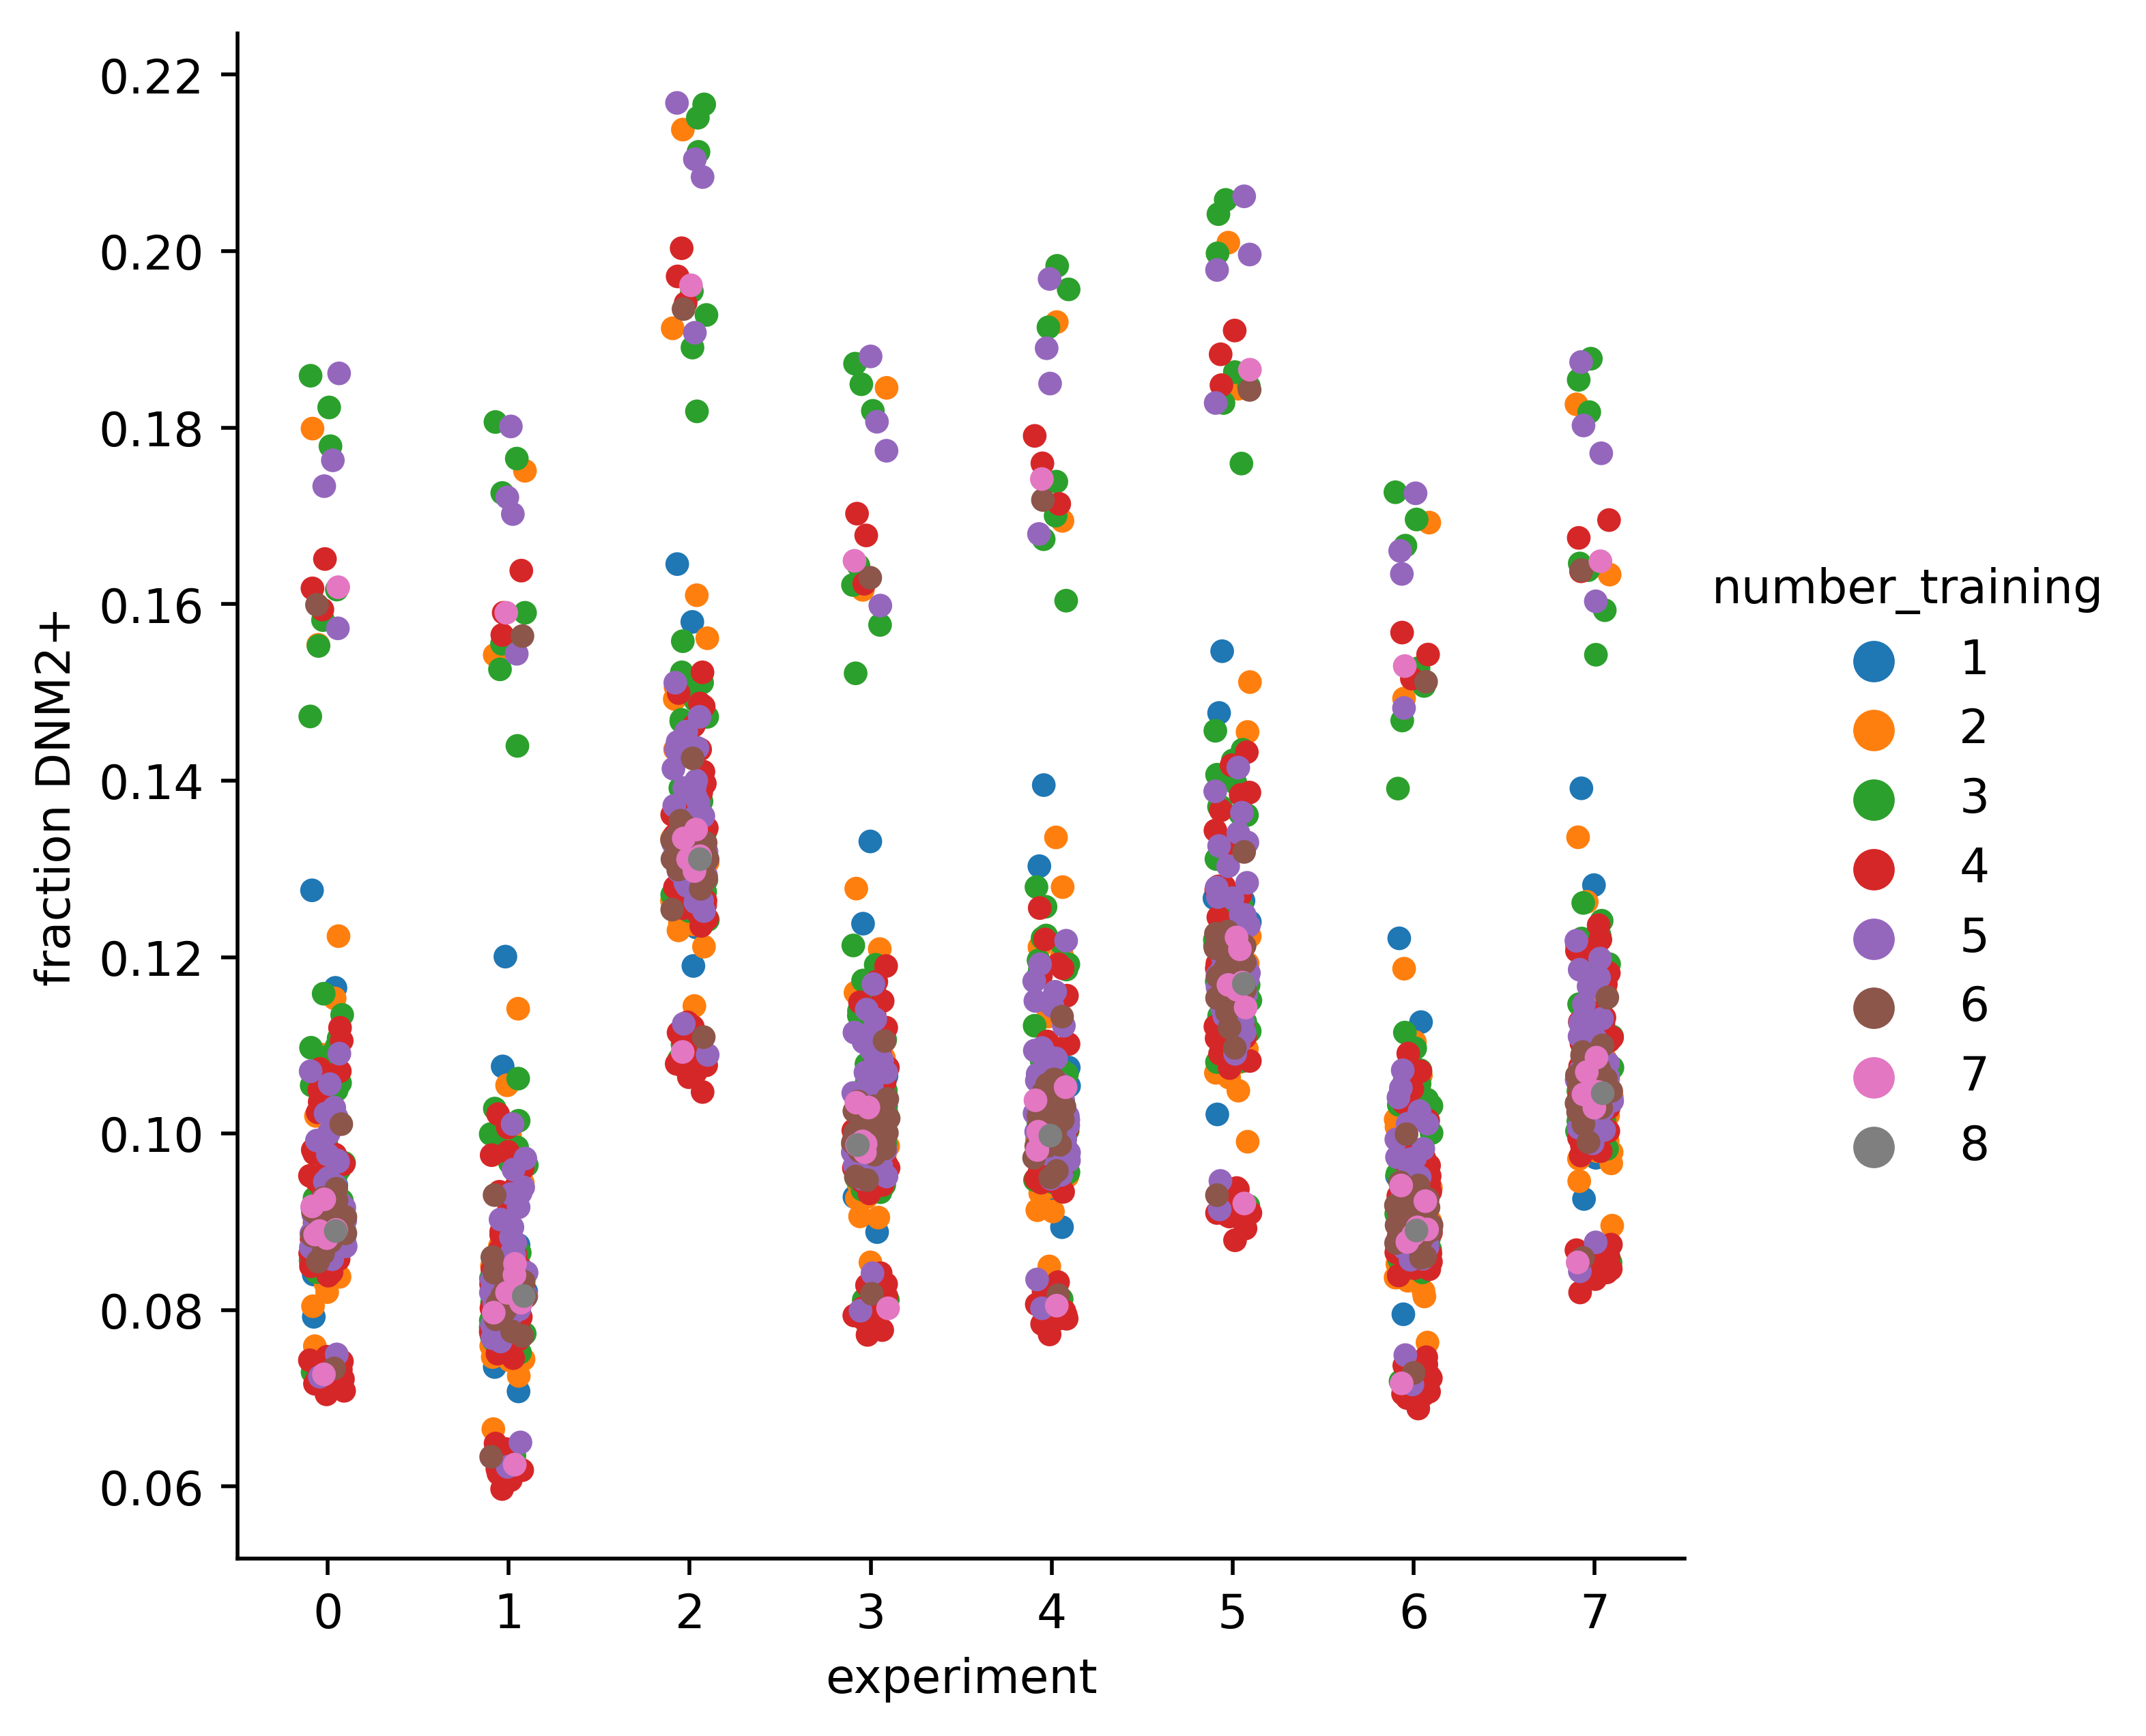

In [52]:
Image(filename=unique_user_saved_outputs+'/plots/fractiondnm2_exp_num_training.png', height=500, width=500)

In [53]:
pg.homoscedasticity(data=df_fraction_num_training_and_exp_num, dv='fraction', group='experiment')

W      pval  equal_var
levene  0.666526  0.700639       True

In [54]:
pg.anova(data=df_fraction_num_training_and_exp_num, dv='fraction', between='experiment')

Source  ddof1  ddof2           F          p-unc       np2
0  experiment      7   2032  140.610173  3.107493e-169  0.326321

In [55]:
tukey_output = pg.pairwise_tukey(data=df_fraction_num_training_and_exp_num, dv='fraction', between='experiment')

In [56]:
tukey_output

A  B   mean(A)   mean(B)      diff        se          T   p-tukey  \
0   0  1  0.096061  0.087951  0.008111  0.001887   4.298961  0.001000   
1   0  2  0.096061  0.136373 -0.040312  0.001887 -21.366996  0.001000   
2   0  3  0.096061  0.105004 -0.008943  0.001887  -4.740047  0.001000   
3   0  4  0.096061  0.106894 -0.010833  0.001887  -5.742072  0.001000   
4   0  5  0.096061  0.122921 -0.026860  0.001887 -14.236860  0.001000   
5   0  6  0.096061  0.095047  0.001015  0.001887   0.537775  0.900000   
6   0  7  0.096061  0.109855 -0.013794  0.001887  -7.311234  0.001000   
7   1  2  0.087951  0.136373 -0.048422  0.001887 -25.665957  0.001000   
8   1  3  0.087951  0.105004 -0.017053  0.001887  -9.039008  0.001000   
9   1  4  0.087951  0.106894 -0.018944  0.001887 -10.041034  0.001000   
10  1  5  0.087951  0.122921 -0.034970  0.001887 -18.535821  0.001000   
11  1  6  0.087951  0.095047 -0.007096  0.001887  -3.761186  0.004309   
12  1  7  0.087951  0.109855 -0.021904  0.001887 -11.610195  0.001000   
13  2  3  0.136373  0.105004  0.031369  0.001887  16.626949  0.001000   
14  2  4  0.136373  0.106894  0.029479  0.001887  15.624924  0.001000   
15  2  5  0.136373  0.122921  0.013452  0.001887   7.130136  0.001000   
16  2  6  0.136373  0.095047  0.041326  0.001887  21.904771  0.001000   
17  2  7  0.136373  0.109855  0.026518  0.001887  14.055762  0.001000   
18  3  4  0.105004  0.106894 -0.001890  0.001887  -1.002026  0.900000   
19  3  5  0.105004  0.122921 -0.017917  0.001887  -9.496813  0.001000   
20  3  6  0.105004  0.095047  0.009957  0.001887   5.277822  0.001000   
21  3  7  0.105004  0.109855 -0.004851  0.001887  -2.571187  0.167256   
22  4  5  0.106894  0.122921 -0.016027  0.001887  -8.494787  0.001000   
23  4  6  0.106894  0.095047  0.011848  0.001887   6.279848  0.001000   
24  4  7  0.106894  0.109855 -0.002960  0.001887  -1.569161  0.741229   
25  5  6  0.122921  0.095047  0.027874  0.001887  14.774635  0.001000   
26  5  7  0.122921  0.109855  0.013066  0.001887   6.925626  0.001000   
27  6  7  0.095047  0.109855 -0.014808  0.001887  -7.849009  0.001000   

      hedges  
0   0.380160  
1  -1.889498  
2  -0.419166  
3  -0.507775  
4  -1.258975  
5   0.047556  
6  -0.646537  
7  -2.269658  
8  -0.799326  
9  -0.887935  
10 -1.639135  
11 -0.332604  
12 -1.026697  
13  1.470332  
14  1.381723  
15  0.630523  
16  1.937054  
17  1.242961  
18 -0.088610  
19 -0.839810  
20  0.466721  
21 -0.227372  
22 -0.751200  
23  0.555331  
24 -0.138762  
25  1.306531  
26  0.612438  
27 -0.694093

In [57]:
tukey_matrix = np.zeros((8,8))
comparison_matrix = np.zeros((8,8))

tukey_values = tukey_output.values

compared_indices = [(int(tukey_values[row, 0]), int(tukey_values[row, 1])) for row in range(tukey_values.shape[0])]
possible_indices = [(i, j) for i in range(8) for j in range(8)]

for row in range(tukey_values.shape[0]):
    
    tukey_matrix[int(tukey_values[row, 0]), int(tukey_values[row, 1])] = tukey_values[row, -2]
    
for idx in possible_indices:
    
    if idx not in compared_indices:
        
        tukey_matrix[idx[0], idx[1]] = np.NaN

In [58]:
class MidpointNormalize(mpl.colors.Normalize): # https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [59]:
%%capture

plt.style.use('default')

plt.rcParams['figure.dpi']=500
fig, axs = plt.subplots(1,1, constrained_layout=True, figsize=(3,3))

cmap = 'plasma'

sc = axs.imshow(comparison_matrix, 
                alpha=1, 
                origin='lower', 
                interpolation='none', 
                cmap=cmap,
                aspect='auto')

vmin = 0
vmax = 0.05
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0.01)
cmap = 'bwr'

sc = axs.imshow(tukey_matrix, 
                alpha=0.9, 
                origin='lower', 
                interpolation='none', 
                cmap=cmap,
                norm=norm, 
                aspect='equal')
cba = fig.colorbar(sc,shrink=1, location='right')
cba.set_label('p-value', rotation=270, labelpad=15)
cba.set_alpha(1)
cba.draw_all()

plt.ylabel('experiment number')
plt.xlabel('experiment number')


# Major ticks
axs.set_xticks(np.arange(8))
axs.set_yticks(np.arange(8))

# Labels for major ticks
axs.set_xticklabels(np.arange(8))
axs.set_yticklabels(np.arange(8))

# Minor ticks
axs.set_xticks(np.arange(-.5, 8, 1), minor=True)
axs.set_yticks(np.arange(-.5, 8, 1), minor=True)


for i in range(8):
    
    plt.plot(np.arange(-1,9), np.arange(-1,9)+i, 'k')
    
plt.xlim(-0.5,7.5)
plt.ylim(-0.5,7.5)

# Gridlines based on minor ticks
axs.grid(which='minor', color='w', linestyle='-', linewidth=3)
plt.savefig(unique_user_saved_outputs+'/plots/tukey_matrix_dnm2_comparison.png', bbox_inches='tight')

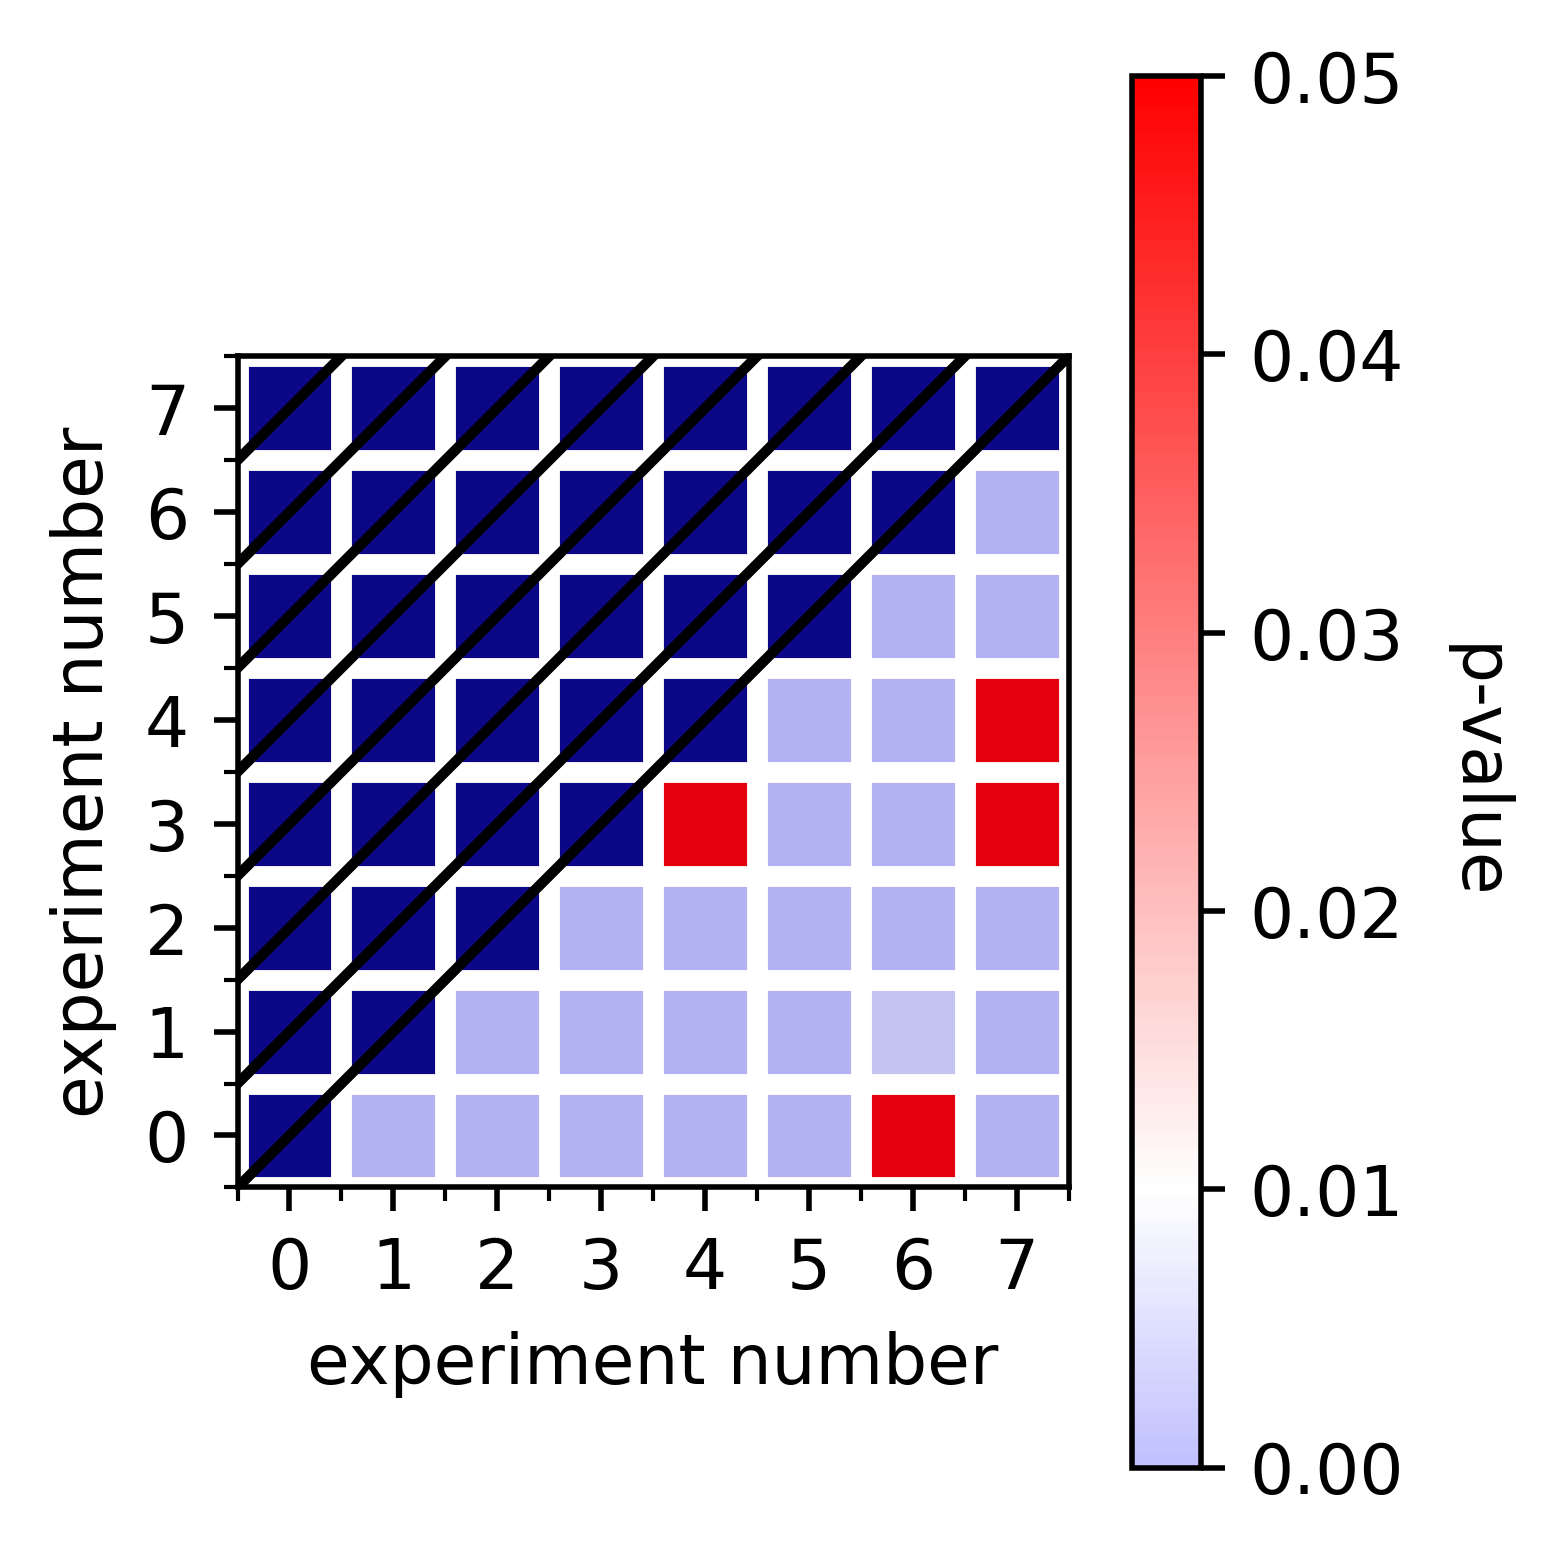

In [60]:
Image(filename=unique_user_saved_outputs+'/plots/tukey_matrix_dnm2_comparison.png', height=500, width=500)

In [61]:
fraction_of_models_event_dnm2pos = np.zeros((df_merged_features.shape[0]))
for dnm2_pos_list in indices_dnm2_positive_all_models:
    
    for idx in dnm2_pos_list:
        
        fraction_of_models_event_dnm2pos[idx] = fraction_of_models_event_dnm2pos[idx] + 1

fraction_of_models_event_dnm2pos = 1/len(indices_dnm2_positive_all_models)*fraction_of_models_event_dnm2pos

In [62]:
normal_scaler = preprocessing.QuantileTransformer(output_distribution='normal', random_state=817)
normal_scaled_data = normal_scaler.fit_transform(df_merged_features.values[:,:len(feature_units)])

pc_model = PCA(n_components=2, random_state=817)
reduced_data = pc_model.fit_transform(normal_scaled_data)

gmm = GMM(n_components=5, random_state=817)

gmm_prediction = gmm.fit_predict(reduced_data)

In [63]:
%%capture
plt.style.use('default')
plt.rcParams['figure.dpi']=500
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=500)

h=0.01 # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 4, reduced_data[:, 1].max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = gmm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = np.max(Z, axis=1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)

vmin = 0.4
vmax = 1
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0.99999999)
cmap = 'bwr'

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           aspect='auto', origin='lower', alpha=0.2,
           norm=norm,
           cmap=cmap)

sc = ax.scatter(df_pcs_normal_scaled_with_gmm_cluster['PC-0'],
           df_pcs_normal_scaled_with_gmm_cluster['PC-1'],
           s=1,
           alpha=0.1)

plt.xlabel('PC-0')
plt.ylabel('PC-1')
plt.ylim([-7, 11])
plt.xlim([-9, 13])
plt.xticks([-5, 0, 5, 10], labels=[-5, 0, 5, 10])
plt.yticks([-5, 0, 5, 10], labels=[-5, 0, 5, 10])
plt.title('principal components of valid tracks\nmapped to feature-space\nblue lines indicate 95% probability\nboundaries between clusters')
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/cluster_boundaries.png', bbox_inches='tight')

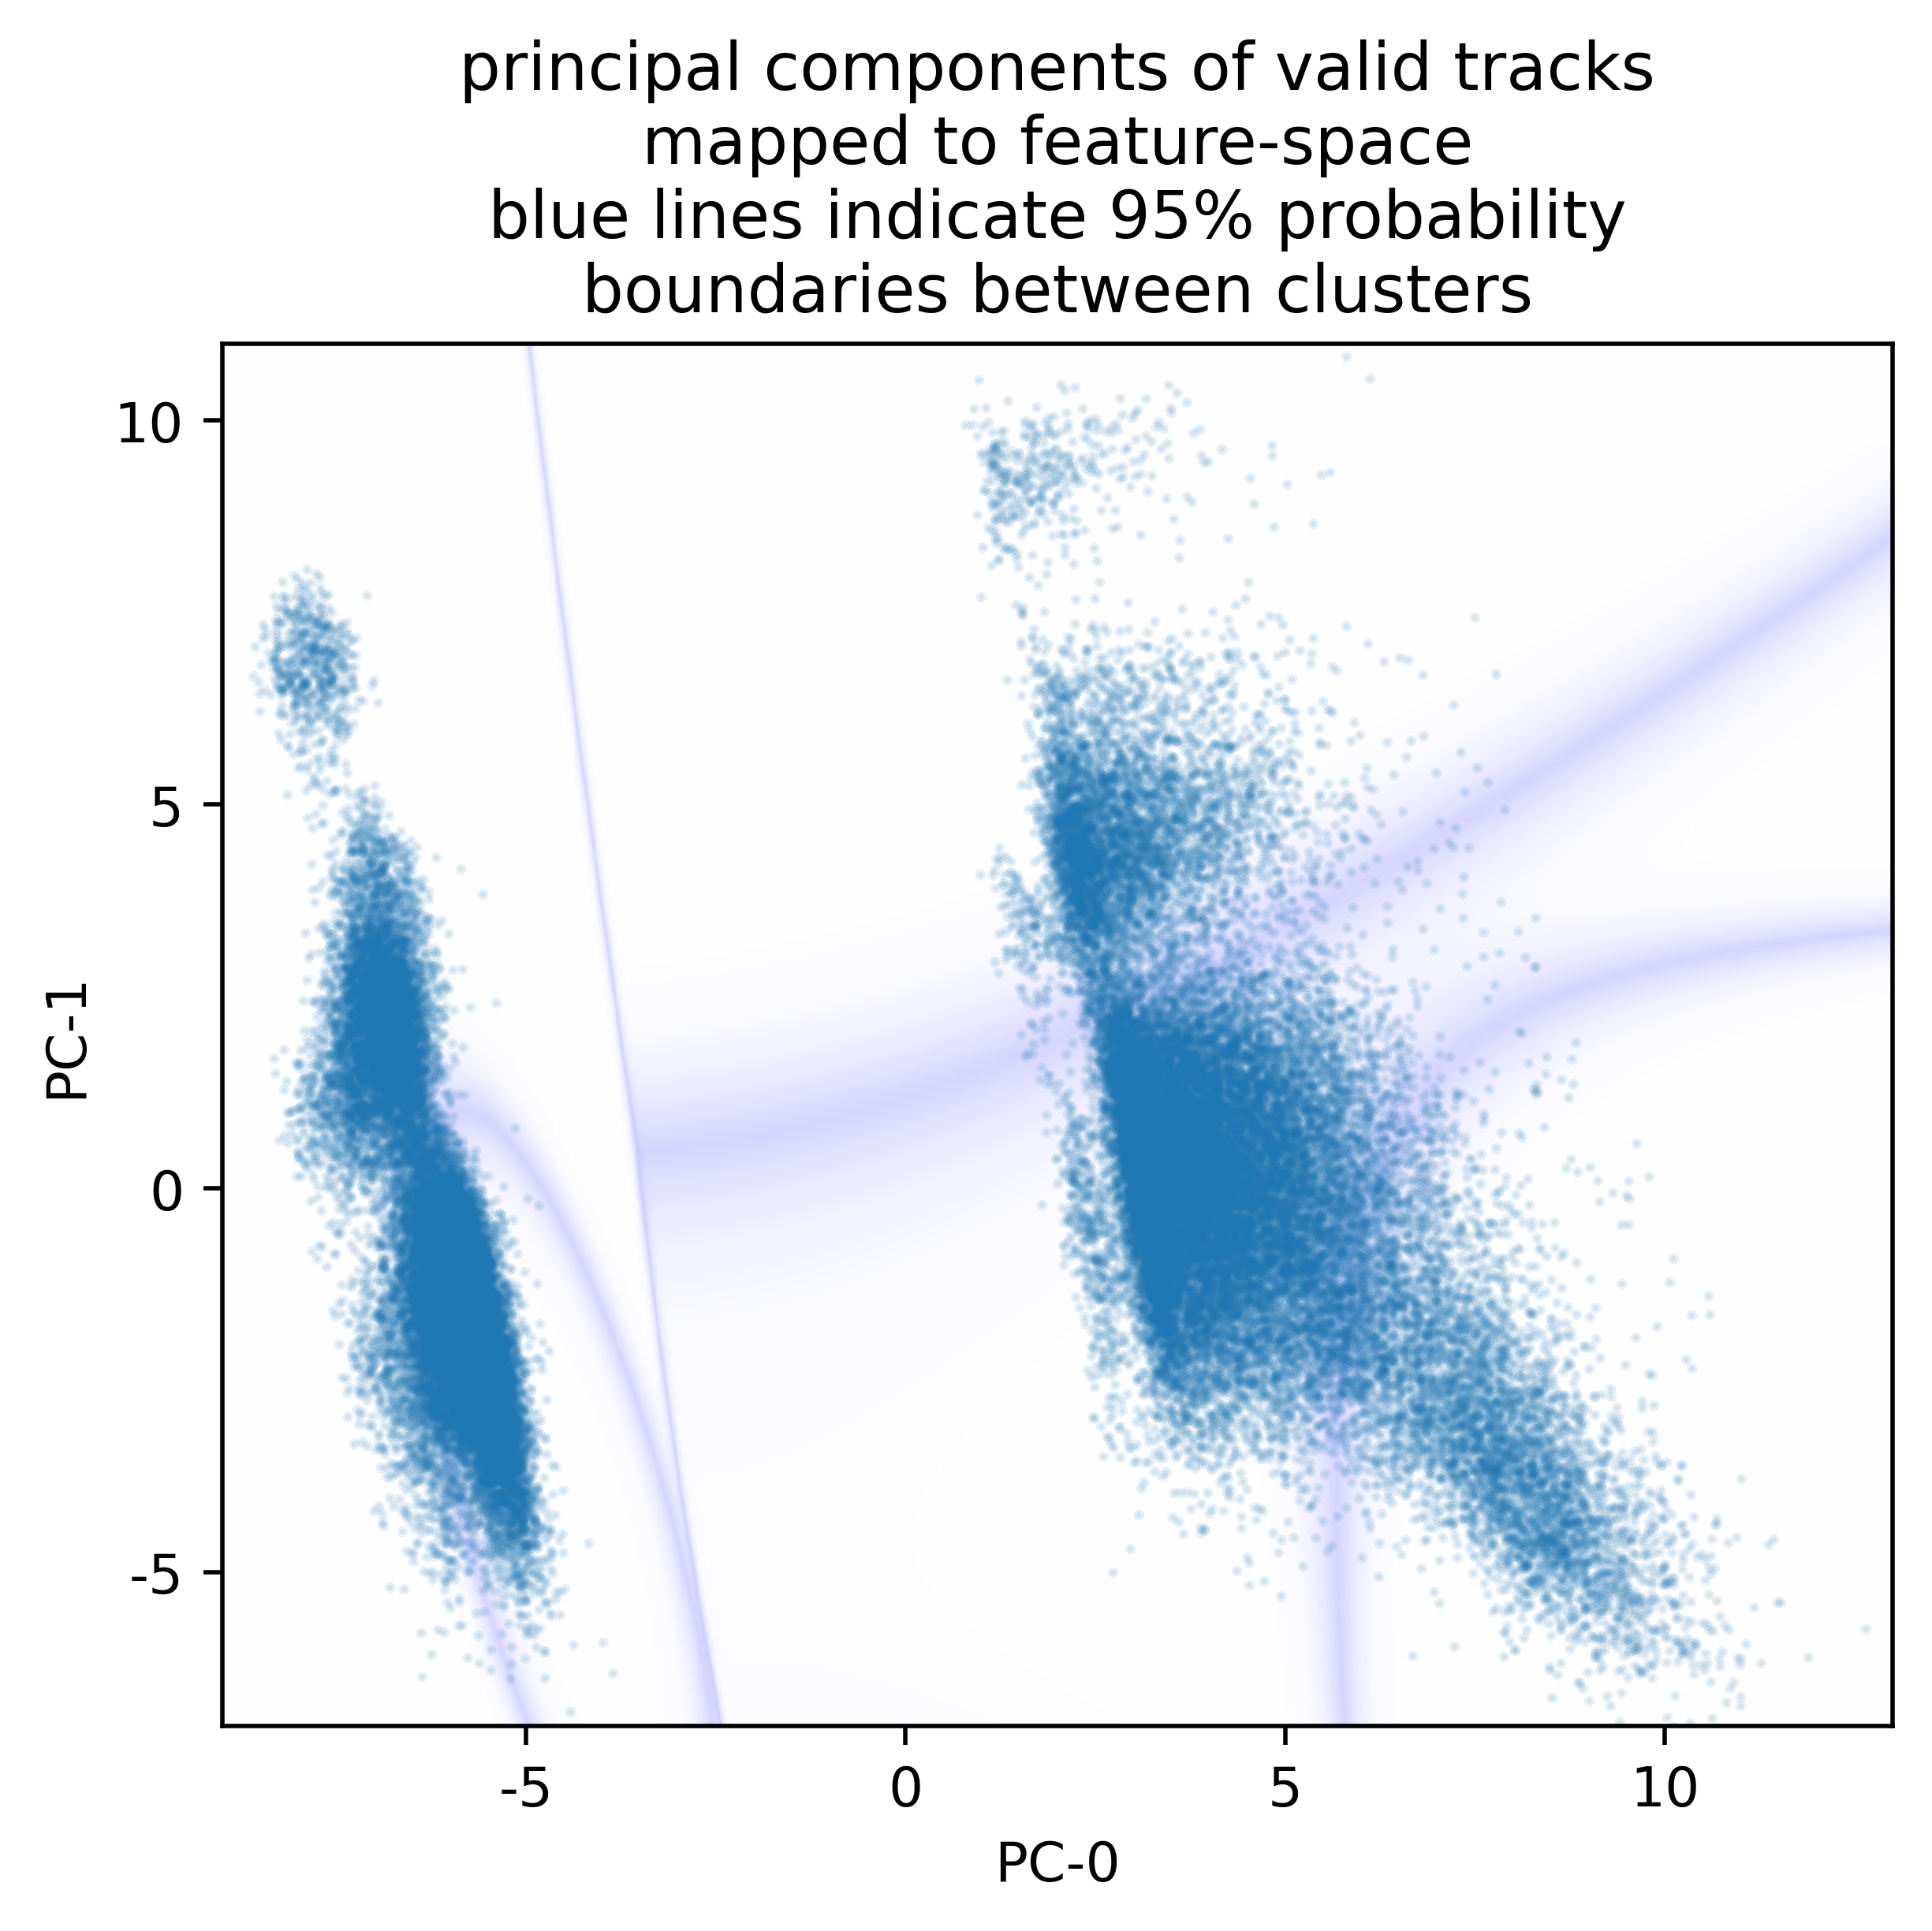

In [64]:
Image(filename=unique_user_saved_outputs+'/plots/cluster_boundaries.png', height=500, width=500)

In [65]:
%%capture
plt.style.use('default')
# plt.rcParams['figure.dpi']=500
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=500)

h=0.01 # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 4, reduced_data[:, 1].max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = gmm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = np.max(Z, axis=1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)

vmin = 0.4
vmax = 1
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0.99999999)
cmap = 'bwr'

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           aspect='auto', origin='lower', alpha=0.6,
           norm=norm,
           cmap=cmap)

sc = ax.scatter(df_pcs_normal_scaled_with_gmm_cluster['PC-0'],
           df_pcs_normal_scaled_with_gmm_cluster['PC-1'],
           c=fraction_of_models_event_dnm2pos,
           s=1,
           alpha=1)
cba = fig.colorbar(sc,shrink=1)
cba.set_label('% of models that \nconsider event DNM2+', rotation=270, labelpad=25)
cba.set_alpha(1)
plt.xlabel('PC-0')
plt.ylabel('PC-1')
plt.ylim([-7, 11])
plt.xlim([-9, 13])
plt.xticks([-5, 0, 5, 10], labels=[-5, 0, 5, 10])
plt.yticks([-5, 0, 5, 10], labels=[-5, 0, 5, 10])
plt.title('principal components of valid tracks\nmapped to feature-space\n blue lines indicate boundaries between clusters')
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/fraction_models_consider_event_dnm2pos_overlaid_pcs_temp.png', bbox_inches='tight')

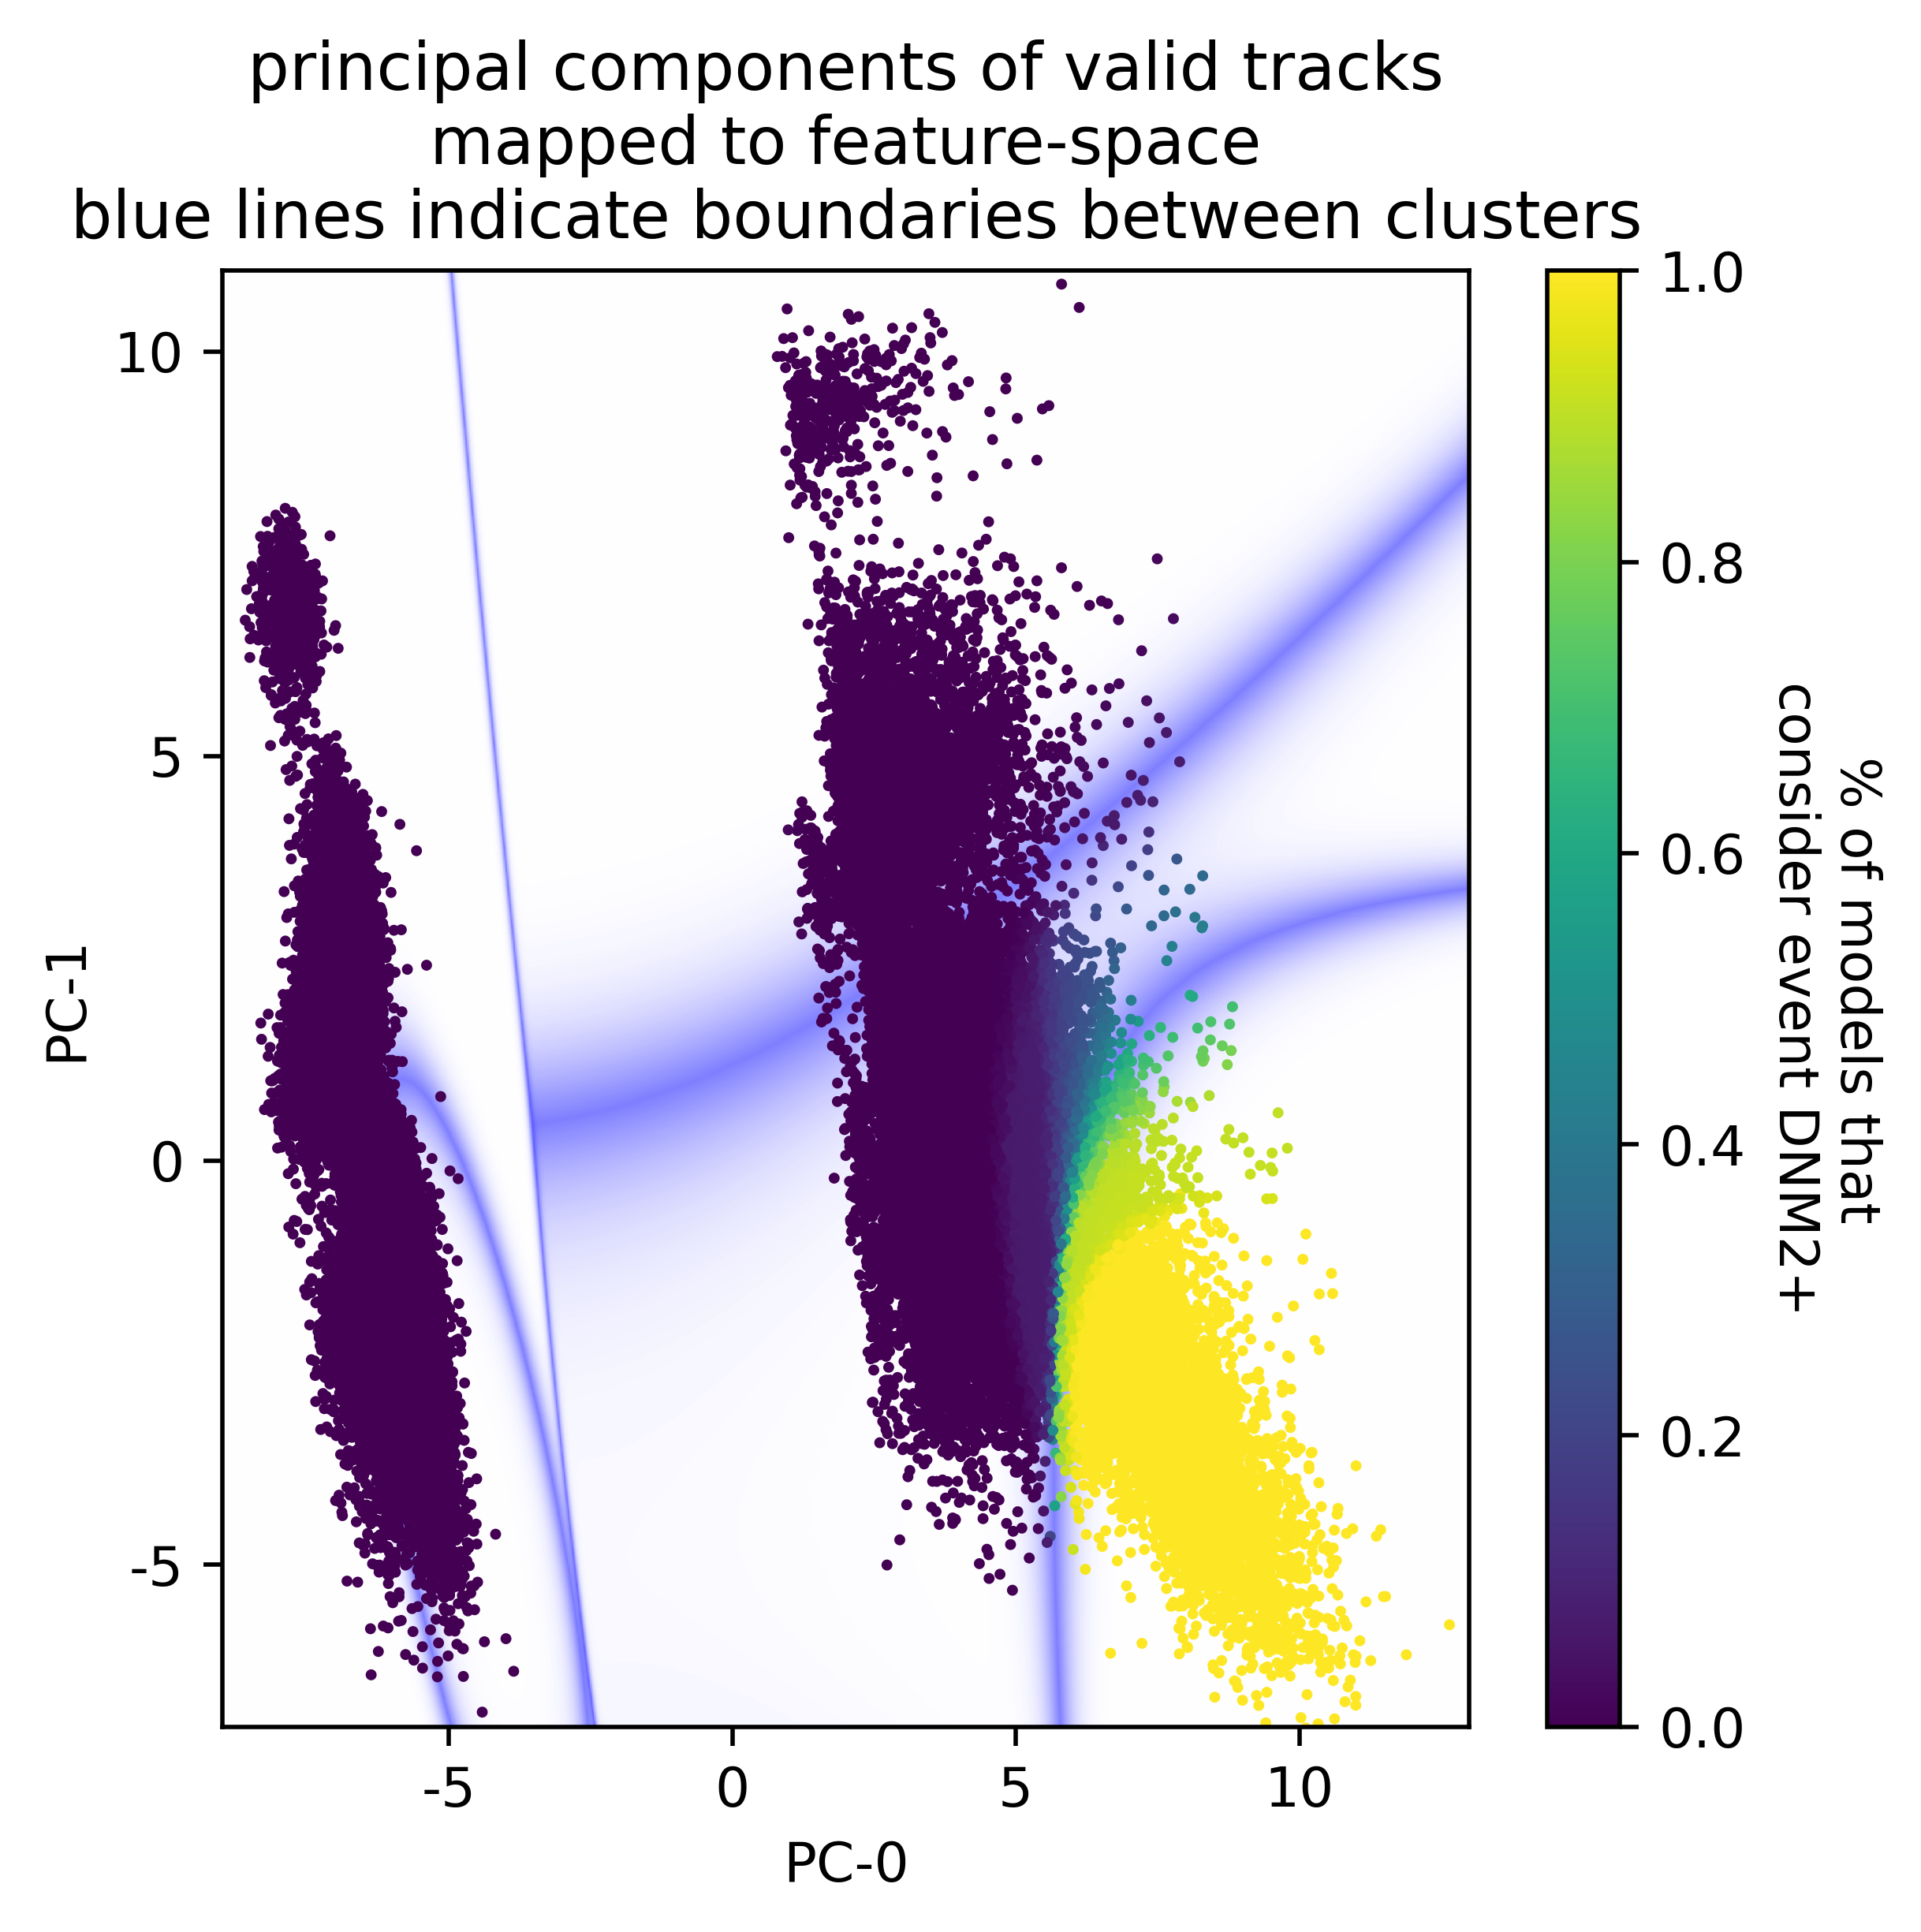

In [66]:
Image(filename=unique_user_saved_outputs+'/plots/fraction_models_consider_event_dnm2pos_overlaid_pcs_temp.png', height=500, width=500)

In [67]:
%%capture

plt.style.use('default')

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=500)

h=0.01 # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 4, reduced_data[:, 1].max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = gmm.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = np.max(Z, axis=1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)

vmin = 0.4
vmax = 1
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0.99999999)
cmap = 'bwr'

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           aspect='auto', origin='lower', alpha=0.6,
           norm=norm,
           cmap=cmap)


sc = ax.scatter(df_pcs_normal_scaled_with_gmm_cluster['PC-0'],
           df_pcs_normal_scaled_with_gmm_cluster['PC-1'],
           c=fraction_of_models_event_dnm2pos,
           s=1,
           alpha=1)
cba = fig.colorbar(sc,shrink=1)
cba.set_label('% of models that \nconsider event DNM2+', rotation=270, labelpad=25)
cba.set_alpha(1)
plt.xlabel('PC-0')
plt.ylabel('PC-1')

plt.xticks([-5, 0, 5, 10], labels=[-5, 0, 5, 10])
plt.yticks([-5, 0, 5, 10], labels=[-5, 0, 5, 10])
ax.set_ylim([-7,4]);
ax.set_xlim([4,13]);
plt.title('principal components of valid tracks\nmapped to feature-space')
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/fraction_models_consider_event_dnm2pos_overlaid_pcs_temp_zoomed.png', bbox_inches='tight')

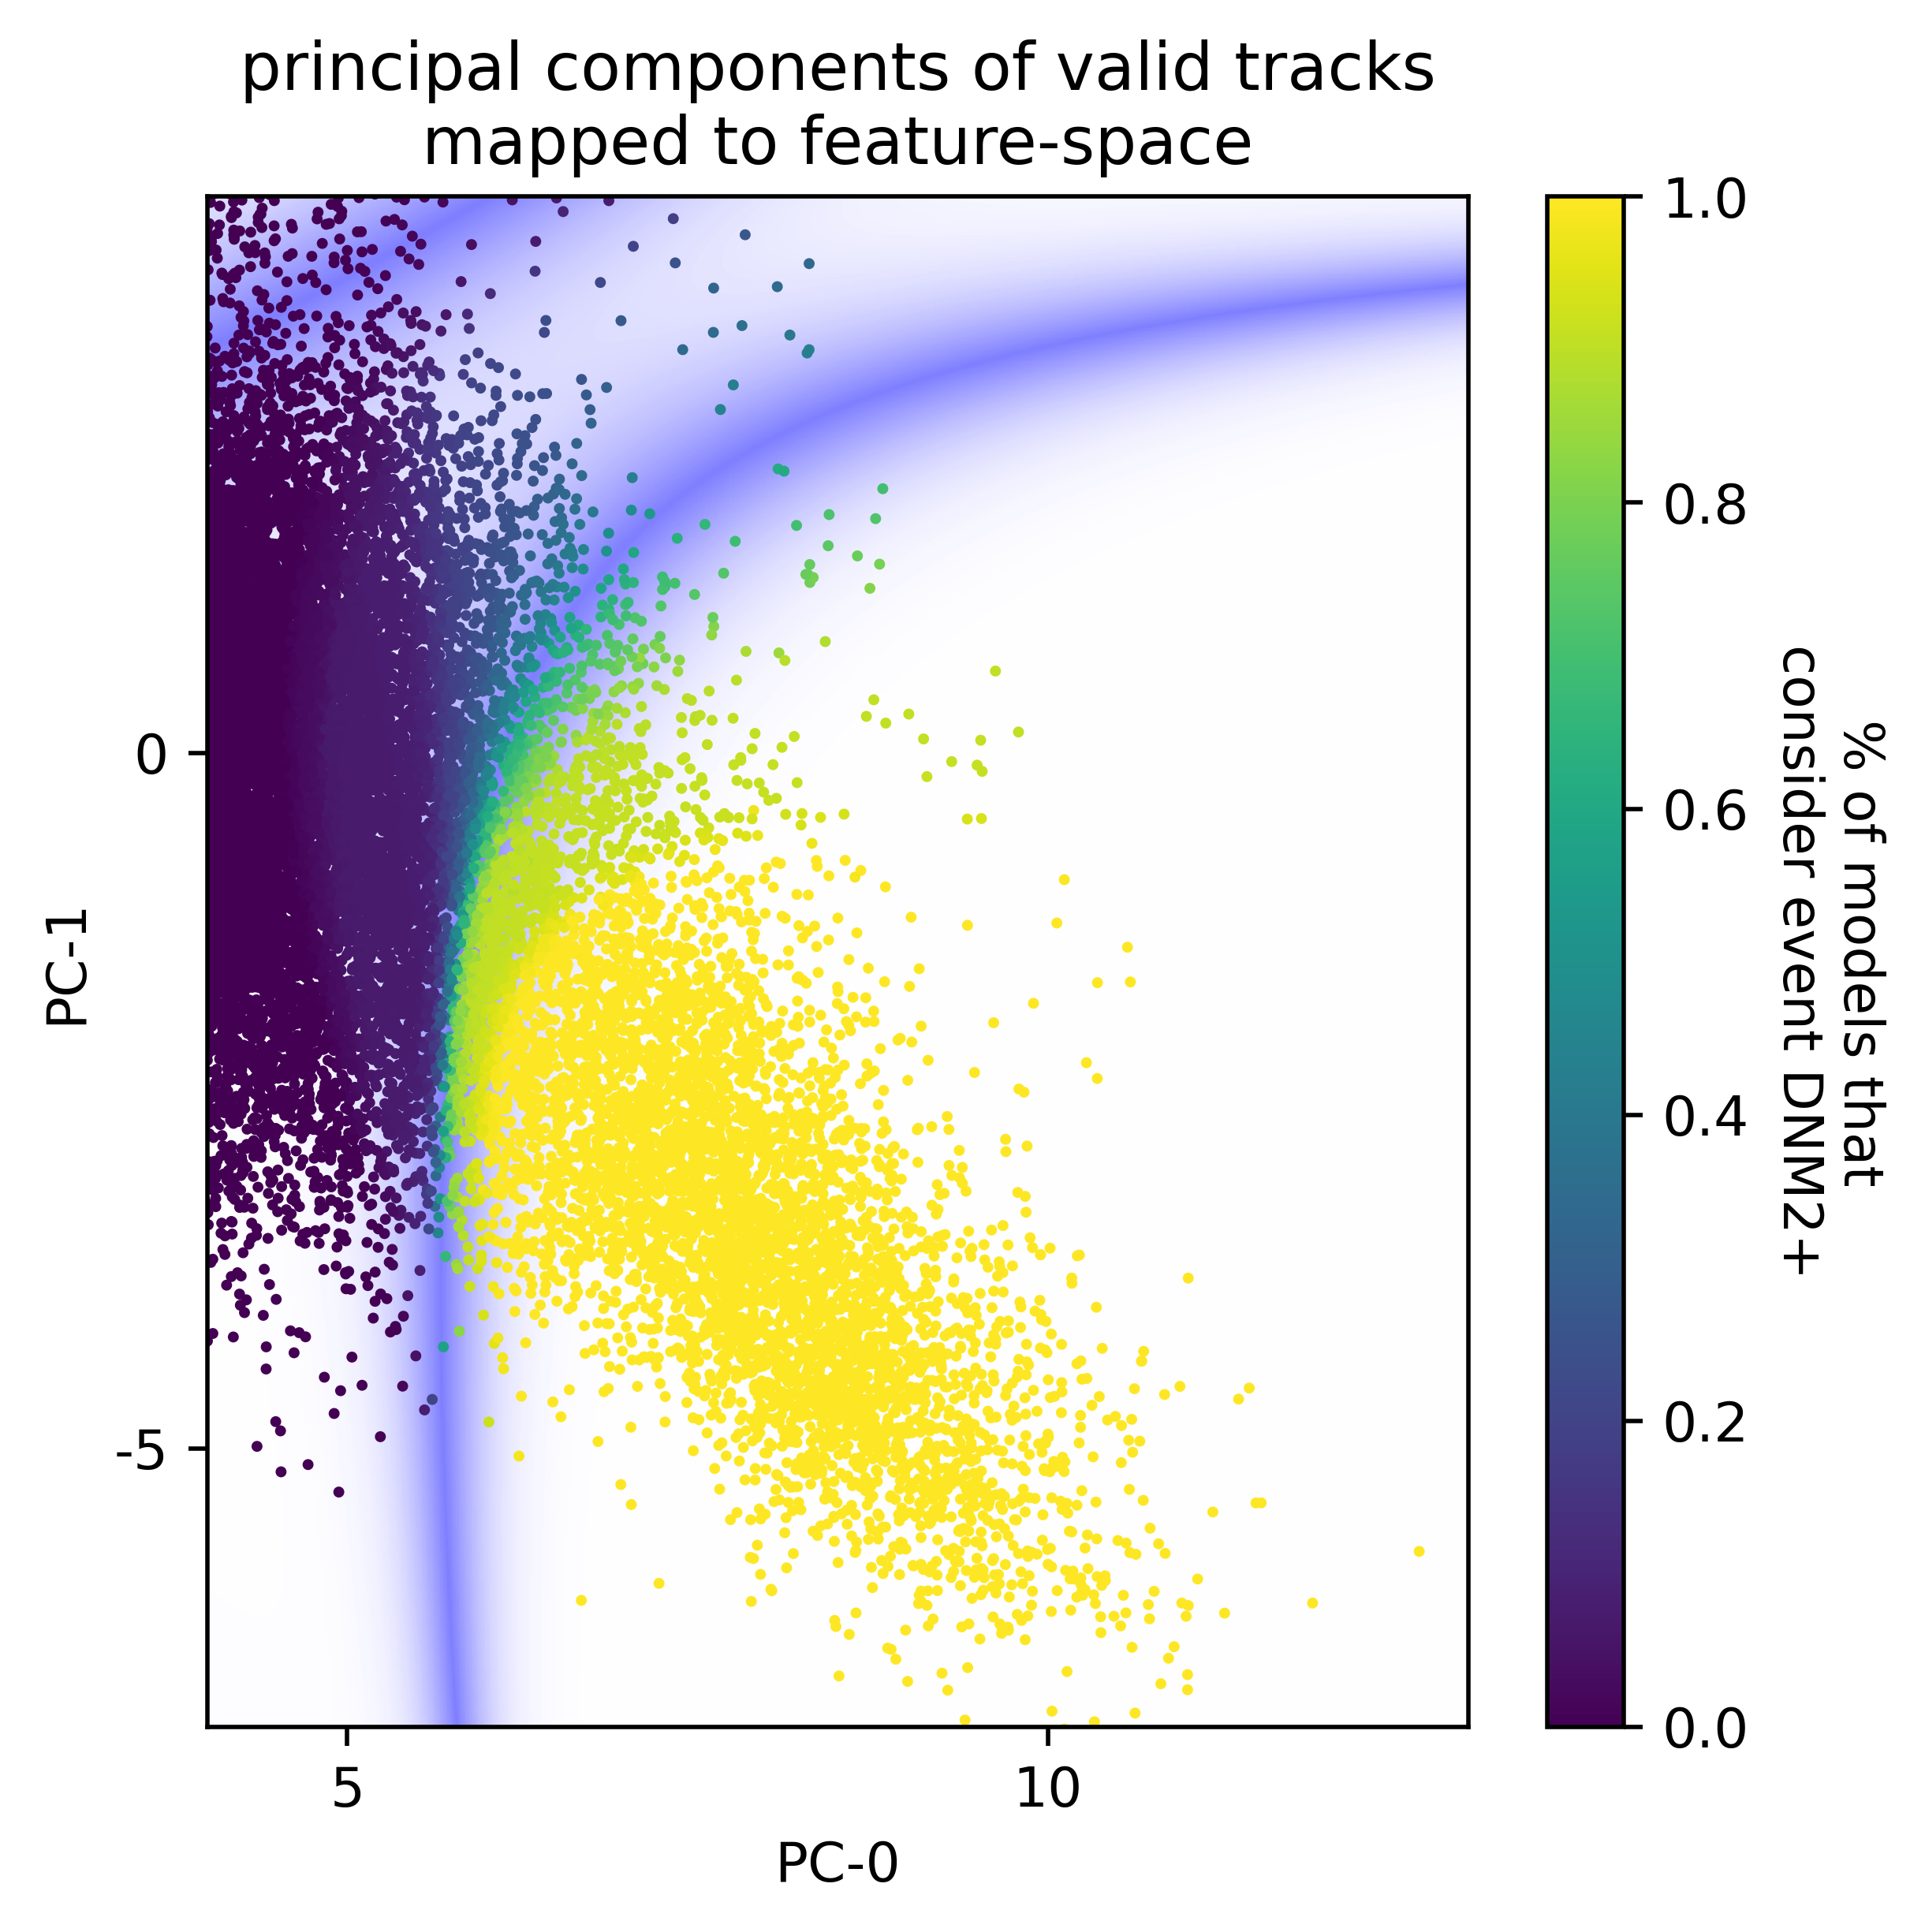

In [68]:
Image(filename=unique_user_saved_outputs+'/plots/fraction_models_consider_event_dnm2pos_overlaid_pcs_temp_zoomed.png', height=500, width=500)